In [1]:
import numpy as np
import pandas as pd
import simpy
import bisect
from collections import namedtuple
from ggplot import *

/Users/vacogivenc/Developer/gov.va/docketeer/env/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/vacogivenc/Developer/gov.va/docketeer/env/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/vacogivenc/Developer/gov.va/docketeer/env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.stdout = open('/dev/stdout', 'w')

In [3]:
class DocketGet(simpy.resources.store.StoreGet):
    def __init__(self, resource, indexes=[0]):
        self.indexes = indexes
        super(DocketGet, self).__init__(resource)
        
class Docket(simpy.resources.store.Store):
    put = simpy.core.BoundClass(simpy.resources.store.StorePut)

    get = simpy.core.BoundClass(DocketGet)
    
    def prepopulate(self, items):
        self.items = items
        self.items.sort()

    def _do_put(self, event):
        if len(self.items) < self._capacity:
            bisect.insort(self.items, event.item)
            event.succeed()

    def _do_get(self, event):
        if len(event.indexes) == 1:
            event.succeed([self.items.pop(event.indexes[0])])
            return

        result = []

        for idx, val in enumerate(event.indexes):
            result.append(self.items[val])
            self.items[val] = self.items[-1-idx]

        if len(event.indexes) > 0:
            del self.items[-len(event.indexes):]
            self.items.sort()

        event.succeed(result)

In [4]:
HOURS_IN_A_YEAR = 260*8
NUM_JUDGES = 100
JUDGE_TENURES = [HOURS_IN_A_YEAR * -1, HOURS_IN_A_YEAR * -5, HOURS_IN_A_YEAR * -99]
NUM_ATTORNEYS_PER_JUDGE_BY_TENURE = [6, 7, 8]
VAR_ATTORNEYS_PER_JUDGE = 1
AVG_NUM_ATTORNEYS_PER_JUDGE = np.mean(NUM_ATTORNEYS_PER_JUDGE_BY_TENURE)
BVA_ANNUAL_THROUGHPUT = 90000
AVG_ATTORNEY_HOURS_PER_CASE = 1 / (BVA_ANNUAL_THROUGHPUT / (NUM_JUDGES * AVG_NUM_ATTORNEYS_PER_JUDGE) / HOURS_IN_A_YEAR)
SD_ATTORNEY_HOURS_PER_CASE = 3
AVG_ARRIVAL_INTERVAL = 1 / (BVA_ANNUAL_THROUGHPUT / HOURS_IN_A_YEAR)
SD_ARRIVAL_INTERVAL = AVG_ARRIVAL_INTERVAL * 0.2
HEARING_RATE = 0.5
PRIORITY_CASE_RATE = 0.2
REMAND_RATE = 0.5
INIT_NUM_CASES = 30000
INIT_HEARING_RATE = 0.5
INIT_PRIORITY_CASE_RATE = 0.02
INIT_REMAND_RATE = 0.25
AVG_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 2
SD_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 1
AVG_REMAND_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 5
SD_REMAND_AGE_AT_ARRIVAL = HOURS_IN_A_YEAR * 2.5
AGE_AT_HEARING = HOURS_IN_A_YEAR * 2

In [5]:
BATCH_SIZE_PER_ATTORNEY = 5
PRIORITY_CASE_XER = 1

In [6]:
env = simpy.Environment()

In [7]:
Judge = namedtuple('Judge', 'id tenure attorneys')
Attorney = namedtuple('Attorney', 'id judge store')
class LegacyAppeal(namedtuple('LegacyAppeal', 'judge priority docketed arrived')):
    def __lt__(self, other):
        return self.docketed < other.docketed

In [8]:
judges = [Judge(i, np.random.choice(JUDGE_TENURES), []) for i in range(NUM_JUDGES)]

In [9]:
def gen_case(hearing_prob, priority_prob, remand_prob, now):
    judge = None
    hearing = np.random.rand() < hearing_prob
    priority = np.random.rand() < priority_prob
    remand = np.random.rand() < remand_prob
    docketed = now - (np.random.normal(AVG_REMAND_AGE_AT_ARRIVAL, SD_REMAND_AGE_AT_ARRIVAL) if remand else np.random.normal(AVG_AGE_AT_ARRIVAL, SD_AGE_AT_ARRIVAL))
    if hearing:
        valid_judges = [j for j in judges if j.tenure <= docketed + AGE_AT_HEARING]
        judge = valid_judges[np.random.randint(1, len(valid_judges)) - 1].id
    return LegacyAppeal(judge, priority, docketed, now)

In [10]:
attorneys = []

for judge in judges:
    tenure_idx = JUDGE_TENURES.index(judge.tenure)
    num_attorneys = NUM_ATTORNEYS_PER_JUDGE_BY_TENURE[tenure_idx] +\
        np.random.randint(-VAR_ATTORNEYS_PER_JUDGE, VAR_ATTORNEYS_PER_JUDGE)
    for i in range(num_attorneys):
        store = simpy.Store(env)
        num_cases = np.random.randint(2, BATCH_SIZE_PER_ATTORNEY + 2)
        store.items = [gen_case(0, 0, 0, 0) for i in range(num_cases)]
        attorney = Attorney("%d-%d" % (judge.id, i), judge, store)
        judge.attorneys.append(attorney)
        attorneys.append(attorney)

In [11]:
legacy_docket = Docket(env)
legacy_docket.prepopulate([gen_case(INIT_HEARING_RATE, INIT_PRIORITY_CASE_RATE, INIT_REMAND_RATE, 0)
                           for i in range(INIT_NUM_CASES)])

In [12]:
def select_cases_for_judge(judge, cases, now, data):
    batch_size = len(judge.attorneys) * BATCH_SIZE_PER_ATTORNEY
    total_batch_size = len(attorneys) * BATCH_SIZE_PER_ATTORNEY
    
    priority_cases, nonpriority_cases = [], []
    priority_hearing_cases, priority_genpop_cases = [], []
    
    for idx, case in enumerate(cases):
        t = (idx, case)
        if case.priority:
            priority_cases.append(t)
            if case.judge is None:
                priority_genpop_cases.append(t)
            elif case.judge == judge.id:
                priority_hearing_cases.append(t)
        else:
            nonpriority_cases.append(t)

    priority_count = len(priority_cases)
    net_docket_range = total_batch_size - priority_count

    assignable_cases = nonpriority_cases[:net_docket_range]
    hearing_cases, genpop_cases = [], []

    for idx, case in assignable_cases:
        t = (idx, case)
        if case.judge is None:
            genpop_cases.append(t)
        elif case.judge == judge.id:
            hearing_cases.append(t)
            
    priority_hearing_cases.sort(key=lambda t: t[1].arrived)

    selected_cases = priority_hearing_cases + hearing_cases

    if len(selected_cases) < batch_size:
        remaining = batch_size - len(selected_cases)
        total_genpop_count = len(genpop_cases) + len(priority_genpop_cases)
        genpop_priority_rate = len(priority_genpop_cases) / total_genpop_count if total_genpop_count > 0 else 0
        target_genpop_priority_count = int(np.ceil(remaining * genpop_priority_rate * PRIORITY_CASE_XER))

        priority_genpop_cases.sort(key=lambda t: t[1].arrived)

        selected_cases = selected_cases + priority_genpop_cases[:target_genpop_priority_count] + genpop_cases
        
        if len(selected_cases) < batch_size:
            extra_cases = [(idx, case)
                           for idx, case in nonpriority_cases[net_docket_range:]
                           if not case.judge or case.judge == judge.id]
            
            selected_cases = selected_cases + extra_cases
            
    selected_cases = selected_cases[:batch_size]
    selected_indexes = [idx for idx, case in selected_cases]
    
    data['distribution_batches'].append({
        'time': now,
        'judge_id': judge.id,
        'judge_tenure': judge.tenure / -HOURS_IN_A_YEAR,
        'total_available': len(cases),
        'priority_available': priority_count,
        'requested': batch_size,
        'total_dist': len(selected_cases),
        'hearing_dist': len([idx for idx, case in selected_cases if case.judge]),
        'priority_dist': len([idx for idx, case in selected_cases if case.priority]),
        'max_index': max([idx for idx, case in selected_cases if not case.priority], default = 0)
    })
    
    for idx, case in selected_cases:
        data['distribution_cases'].append({
            'time': now,
            'arrived': case.arrived,
            'priority': case.priority,
            'hearing': case.judge is not None
        })
    
    return selected_indexes

In [13]:
def legacy_appeal_arrives(env, docket):
    while True:
        interval = abs(np.random.normal(AVG_ARRIVAL_INTERVAL, SD_ARRIVAL_INTERVAL))
        yield env.timeout(interval)
        yield docket.put(gen_case(HEARING_RATE, PRIORITY_CASE_RATE, REMAND_RATE, env.now))
        # print('Added a new appeal', 'at', env.now)

arrival_proc = env.process(legacy_appeal_arrives(env, legacy_docket))

In [14]:
data = {
    'distribution_batches': [],
    'distribution_cases': []
}

def attorney_works_appeal(attorney, env, docket, data):
    while True:
        if len(attorney.store.items) <= 1:
            # print('attorney', attorney.id, 'needs more appeals')
            indexes = select_cases_for_judge(attorney.judge, docket.items, env.now, data)
            cases = yield docket.get(indexes)
            stores = [atty.store for atty in attorney.judge.attorneys]
            for case in cases:
                emptiest_plate = min(stores, key=lambda store: len(store.items))
                yield emptiest_plate.put(case)
            # print('judge', attorney.judge.id, 'retrieved', len(indexes), 'appeals at', env.now)
        yield attorney.store.get()
        # print(attorney.id, 'started working an appeal', 'at', env.now)
        interval = abs(np.random.normal(AVG_ATTORNEY_HOURS_PER_CASE, SD_ATTORNEY_HOURS_PER_CASE))
        yield env.timeout(interval)
        # print(attorney.id, 'finished working an appeal', 'at', env.now)

attorney_procs = [env.process(attorney_works_appeal(attorney, env, legacy_docket, data))
                  for attorney in attorneys]

In [15]:
env.run(HOURS_IN_A_YEAR)

In [16]:
batches_df = pd.DataFrame(data['distribution_batches'])
batches_df['day'] = batches_df['time'] / 8
batches_df['judge_id'] = batches_df['judge_id'].astype(str)
batches_df['judge_tenure'] = batches_df['judge_tenure'].astype(str)


cases_df = pd.DataFrame(data['distribution_cases'])
cases_df['day'] = cases_df['time'] / 8
priority_cases_df = cases_df[cases_df['priority']].copy()
priority_cases_df['days_to_distribution'] = (priority_cases_df['time'] - priority_cases_df['arrived']) / 8

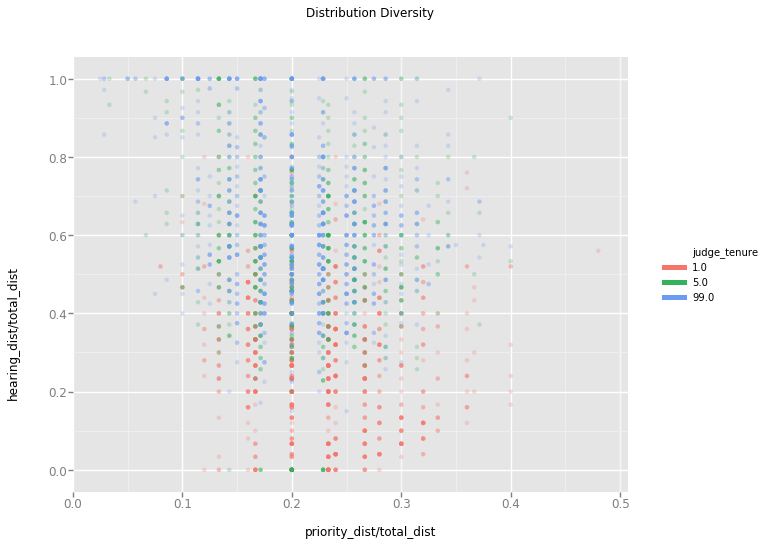

<ggplot: (-9223372036562405544)>

In [17]:
ggplot(aes(x='priority_dist/total_dist', y='hearing_dist/total_dist', color = 'judge_tenure'), data=batches_df) +\
    geom_point(alpha=0.25) +\
    ggtitle("Distribution Diversity")

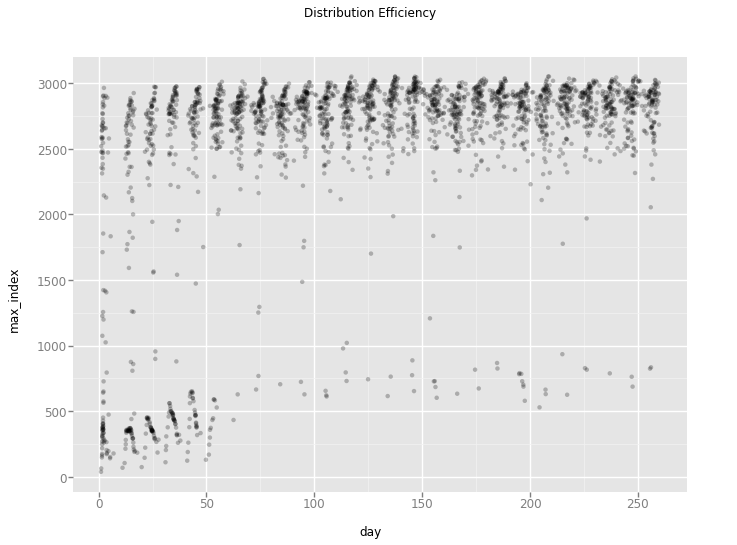

<ggplot: (-9223372036559358541)>

In [18]:
ggplot(aes(x='day', y='max_index'), data=batches_df) +\
    geom_point(alpha=0.25) +\
    ggtitle("Distribution Efficiency")

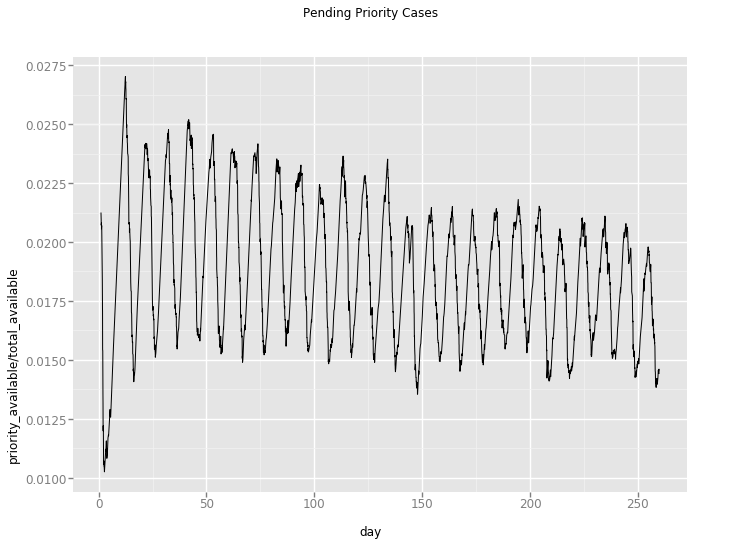

<ggplot: (-9223372036562400126)>

In [19]:
ggplot(aes(x='day', y='priority_available/total_available'), data=batches_df) +\
    geom_line() +\
    ggtitle("Pending Priority Cases")

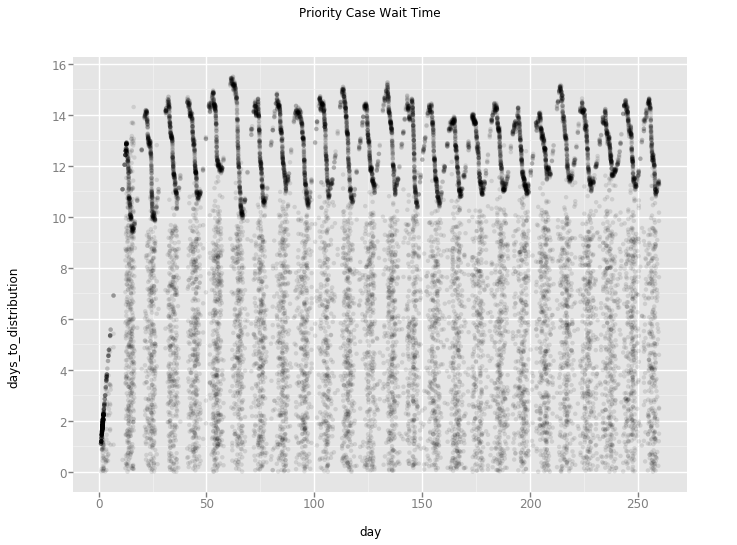

<ggplot: (-9223372036562966903)>

In [20]:
ggplot(aes(x='day', y='days_to_distribution'), data=priority_cases_df) +\
    geom_point(alpha=0.1) +\
    ggtitle("Priority Case Wait Time")